In [5]:
# ===================== LOAD LIBRARIES ======================
# ===========================================================

import numpy as np
import grids as gr
import field_conditions as fc
import integrators as it
from matplotlib import pyplot as plt
import operators as op
import functools as ft
import AnimPlayer
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

plt.style.use("mplstyles/myclassic_white.mplstyle")

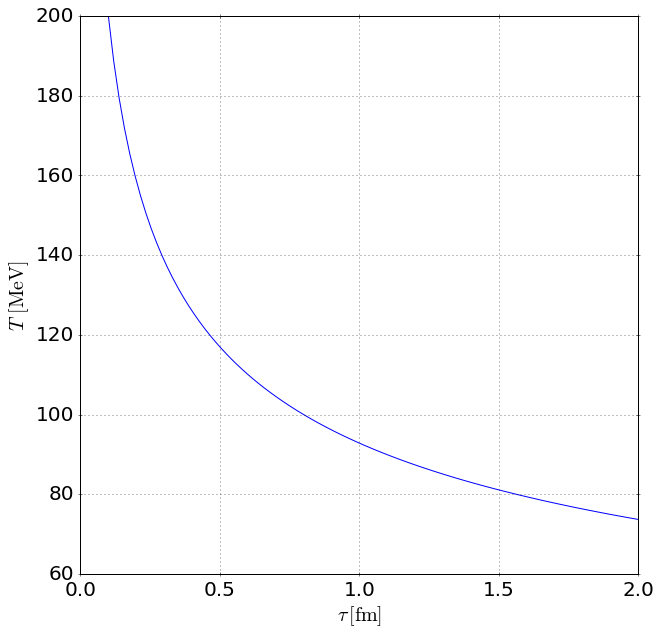

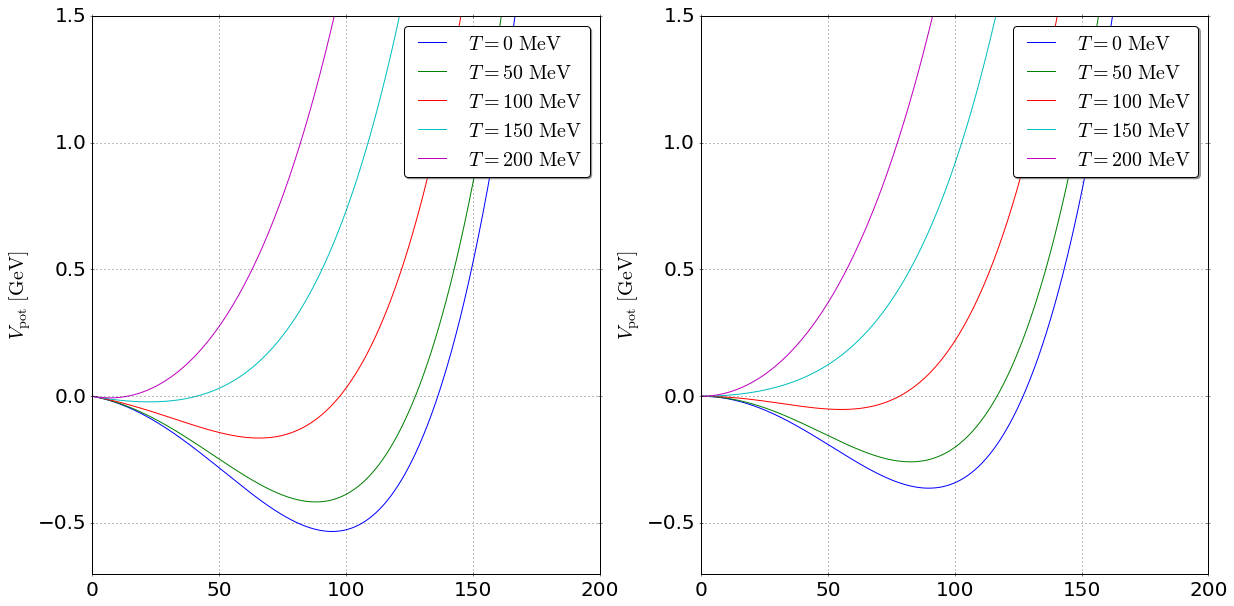

In [6]:
# =============== DEFINE PHYSICAL PARAMETERS ================
# ===========================================================

%matplotlib inline

fpi = 94.5 # MeV
mpi = 140 # MeV
msigma = 600 # MeV

T0 = 200
tau0 = 0.1
tauf = 2

def T(tau,r):
    return T0 * (tau/tau0)**(-1/3)

fig, ax = plt.subplots(figsize=(10,10))

taus = np.linspace(tau0,tauf,100)
ax.plot(taus,T(taus,0),marker="")
ax.set_ylabel(r"$T\ [\mathrm{MeV}]$")
ax.set_xlabel(r"$\tau\,[\mathrm{fm}]$")
plt.show()

lam = (msigma**2/2 + mpi**2)/(fpi**2)

def V(sigma, pi1, pi2, pi3,T):
    rho2 = (sigma**2 + pi1**2 + pi2**2 + pi3**3)
    return lam/4 * (rho2**2) -lam/2 * rho2 * (fpi**2 -mpi**2/lam - T**2/2) - fpi*mpi**2 * sigma

fig, (axsig, axpi) = plt.subplots(ncols=2,figsize=(20,10))
Ts = np.linspace(0,200,5)
xs = np.linspace(0,200,1000)

scale = 1e-9

for thisT in Ts:
    axsig.plot(xs,scale*V(xs,0,0,0,thisT),
        label=r"$T={%.0f}\ \mathrm{MeV}$"%(thisT),
        marker="")
    axpi.plot(xs,scale*V(0,xs,0,0,thisT),
        label=r"$T={%.0f}\ \mathrm{MeV}$"%(thisT),
        marker="")

axsig.set_ylim(-0.7,1.5)
axpi.set_ylim(-0.7,1.5)

axsig.set_ylabel(r"$V_\mathrm{pot}\ [\mathrm{GeV}]$")
axpi.set_ylabel(r"$V_\mathrm{pot}\ [\mathrm{GeV}]$")

axsig.legend()
axpi.legend()
plt.show()

In [7]:
# ================== DEFINE ODE SYSTEM ======================
# ===========================================================

def driver(tau, u, r, nghost=1):
    # unpack state vector
    sigma, pi0, pi1, pi2, Psigma, Ppi0, Ppi1, Ppi2 = u

    fields = (sigma, pi0, pi1, pi2)
    Pfields = (Psigma, Ppi0, Ppi1, Ppi2)

    rho2 = np.sum(np.array([f**2 for f in fields]), axis=0)

    # calculate all necessary derivatives
    Dfields, DPfields = [], []

    for (idx, (field, Pfield)) in enumerate(list(zip(fields, Pfields))):
        dr_field = gr.ghost_pad(op.D1(field, r, nghost=nghost), nghost=nghost)
        ddr_field = gr.ghost_pad(op.D2(field, r, nghost=nghost), nghost=nghost)

        # impose parity conditions
        fc.BC_parity(dr_field, is_even=False, left_side=True, nghost=nghost)
        fc.BC_parity(ddr_field, is_even=True, left_side=True, nghost=nghost)

        # impose extrapolation (outflow) conditions
        fc.BC_outflow(dr_field, nghost=nghost, order=1)
        fc.BC_outflow(ddr_field, nghost=nghost, order=1)

        # time step
        Dfield = Pfield
        DPfield = -1/tau * Pfield + ddr_field + 1/r * dr_field + lam * (fpi**2 -mpi**2/lam - T(tau,r)**2/2 - rho2) * field + (idx == 0) * fpi*mpi**2

        # impose parity conditions
        fc.BC_parity(Dfield, is_even=True, left_side=True, nghost=nghost)
        fc.BC_parity(DPfield, is_even=True, left_side=True, nghost=nghost)

        # impose extrapolation (outflow) conditions
        fc.BC_outflow(Dfield, nghost=nghost, order=1)
        fc.BC_outflow(DPfield, nghost=nghost, order=1)

        Dfields.append(Dfield)
        DPfields.append(DPfield)

    # return update step
    res = (
        *Dfields,
        *DPfields
    )
    return np.vstack(res)

In [8]:
# ==================== INITIALIZATION =======================
# ===========================================================

# =======================================
# grid parameters
nghost = 2
Nr = 500
r_a, r_b = 0, 30

r = gr.gr_CC(Nr, r_a, r_b, nghost=nghost)
dr = r[1] - r[0]

N_t = 10000
dtau = (tauf - tau0) / N_t

# =======================================
# initial conditions
sigma = (fpi) * np.ones_like(r)
pi0 = np.zeros_like(r)
pi1 = np.zeros_like(r)
pi2 = np.zeros_like(r)
Psigma = np.zeros_like(r)
Ppi0 = np.zeros_like(r)
Ppi1 = np.zeros_like(r)
Ppi2 = np.zeros_like(r)

fields = (sigma, pi0, pi1, pi2)
Pfields = (Psigma, Ppi0, Ppi1, Ppi2)

for (field, Pfield) in list(zip(fields, Pfields)):
    # impose parity conditions
    fc.BC_parity(field, is_even=True, left_side=True, nghost=nghost)
    fc.BC_parity(Pfield, is_even=True, left_side=True, nghost=nghost)

    # impose extrapolation (outflow) conditions
    fc.BC_outflow(field, nghost=nghost, order=1)
    fc.BC_outflow(Pfield, nghost=nghost, order=1)

# =======================================
# set up state vector
u_i = np.vstack((*fields, *Pfields))

In [9]:
# ==================== INITIALIZATION =======================
# ===========================================================

# =======================================
# grid parameters
nghost = 2
Nr = 500
r_a, r_b = 0, 30

r = gr.gr_CC(Nr, r_a, r_b, nghost=nghost)
dr = r[1] - r[0]

N_t = 10000
dtau = (tauf - tau0) / N_t

# =======================================
# initial conditions
sigma = (fpi) * np.ones_like(r)
pi0 = np.zeros_like(r)
pi1 = np.zeros_like(r)
pi2 = np.zeros_like(r)
Psigma = np.zeros_like(r)
Ppi0 = np.zeros_like(r)
Ppi1 = np.zeros_like(r)
Ppi2 = np.zeros_like(r)

fields = (sigma, pi0, pi1, pi2)
Pfields = (Psigma, Ppi0, Ppi1, Ppi2)

for (field, Pfield) in list(zip(fields, Pfields)):
    # impose parity conditions
    fc.BC_parity(field, is_even=True, left_side=True, nghost=nghost)
    fc.BC_parity(Pfield, is_even=True, left_side=True, nghost=nghost)

    # impose extrapolation (outflow) conditions
    fc.BC_outflow(field, nghost=nghost, order=1)
    fc.BC_outflow(Pfield, nghost=nghost, order=1)

# =======================================
# set up state vector
u_i = np.vstack((*fields, *Pfields))

In [10]:
# ================== PERFORM EVOLUTION ======================
# ===========================================================

driver_func = ft.partial(driver, r=r, nghost=nghost)
# =======================================
# evolve
u_c = u_i
hist = [u_i]

tau = tau0
taus = [tau]
for t_idx in range(int(N_t)):
    print("tau=", tau)
    
    u_c = it.ev_step_RK4(tau, u_c, dtau, driver_func)

    tau = tau + dtau
    taus.append(tau)
    hist.append(u_c)

hist = np.array(hist)

tau= 0.1
tau= 0.10019
tau= 0.10038
tau= 0.10056999999999999
tau= 0.10075999999999999
tau= 0.10094999999999998
tau= 0.10113999999999998
tau= 0.10132999999999998
tau= 0.10151999999999997
tau= 0.10170999999999997
tau= 0.10189999999999996
tau= 0.10208999999999996
tau= 0.10227999999999995
tau= 0.10246999999999995
tau= 0.10265999999999995
tau= 0.10284999999999994
tau= 0.10303999999999994
tau= 0.10322999999999993
tau= 0.10341999999999993
tau= 0.10360999999999992
tau= 0.10379999999999992
tau= 0.10398999999999992
tau= 0.10417999999999991
tau= 0.10436999999999991
tau= 0.1045599999999999
tau= 0.1047499999999999
tau= 0.1049399999999999
tau= 0.10512999999999989
tau= 0.10531999999999989
tau= 0.10550999999999988
tau= 0.10569999999999988
tau= 0.10588999999999987
tau= 0.10607999999999987
tau= 0.10626999999999986
tau= 0.10645999999999986
tau= 0.10664999999999986
tau= 0.10683999999999985
tau= 0.10702999999999985
tau= 0.10721999999999984
tau= 0.10740999999999984
tau= 0.10759999999999983
tau= 0.10778999999

In [11]:
# ================== ANIMATE THE DATA =======================
# ===========================================================
%matplotlib qt

sigmahist, pi0hist, pi1hist, pi2hist, Psigmahist, Ppi0hist, Ppi1hist, Ppi2hist = np.transpose(hist,(1,0,2))
fieldhists = (sigmahist, pi0hist, pi1hist, pi2hist)
Pfieldhists = (Psigmahist, Ppi0hist, Ppi1hist, Ppi2hist)

fig = plt.figure(figsize=(19,10))
gs = GridSpec(2,4,figure=fig)

axfields, axPfields = [], []
plotfields, plotPfields = [], []
labels = [r"$\sigma$",r"$\pi^0$",r"$\pi^1$",r"$\pi^2$"]

def getlims(a):
    return np.min(a)-0.05*np.ptp(a), np.max(a)+0.05*np.ptp(a)

for (idx, _) in enumerate(fieldhists):
    axfield = fig.add_subplot(gs[0,idx])
    axPfield = fig.add_subplot(gs[1,idx])

    plotfields.append(axfield.plot(r, fieldhists[idx][0])[0])
    plotPfields.append(axPfield.plot(r, Pfieldhists[idx][0])[0])

    axfield.set_title(labels[idx])
    axPfield.set_title(r"$\Pi$"+labels[idx])

    # axfield.set_ylim(getlims(fieldhists[idx]))
    # axPfield.set_ylim(getlims(Pfieldhists[idx]))

    axfields.append(axfield)
    axPfields.append(axPfield)

def update(frame):
    fig.suptitle(r"$tau=$"+str(taus[frame])+" ("+str(frame)+"/"+str(len(taus))+")")

    for (idx, _) in enumerate(fieldhists):
        plotfields[idx].set_ydata(fieldhists[idx][frame])
        plotPfields[idx].set_ydata(Pfieldhists[idx][frame])

        axfields[idx].relim()
        axPfields[idx].relim()

        axfields[idx].autoscale_view()
        axPfields[idx].autoscale_view()


ani = AnimPlayer.Player(fig=fig, func=update,maxi=len(taus)-1)
plt.show()

/media/tobias/data/OneDrive/projects/MasterThesis_HeavyIonCollisions/code/Python/LiSInt/AnimPlayer.py:18: UserWarning: frames=<generator object Player.play at 0x7fbbb55dbf90> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  FuncAnimation.__init__(self,self.fig, self.update, frames=self.play(),


In [12]:
plt.plot(sigmahist[:][0])

In [13]:
sigmahist

array([[94.5       , 94.5       , 94.5       , ..., 94.5       ,
        94.5       , 94.5       ],
       [93.7402905 , 93.7402905 , 93.7402905 , ..., 93.7402905 ,
        93.7402905 , 93.7402905 ],
       [91.48775499, 91.48775499, 91.48775499, ..., 91.48775499,
        91.48775499, 91.48775499],
       ...,
       [98.27242102, 98.27242102, 98.27242102, ..., 98.27242102,
        98.27242102, 98.27242102],
       [97.57645823, 97.57645823, 97.57645823, ..., 97.57645823,
        97.57645823, 97.57645823],
       [96.61853323, 96.61853323, 96.61853323, ..., 96.61853323,
        96.61853323, 96.61853323]])

In [14]:
sigmahist[:,0]

array([94.5       , 93.7402905 , 91.48775499, ..., 98.27242102,
       97.57645823, 96.61853323])

In [15]:
plt.plot(sigmahist[:,0])

In [16]:
plt.plot(sigmahist[:,0])

In [17]:
np.shape(sigmahist[:,0])

(10001,)

In [18]:
plt.plot(taus,sigmahist[:,0])